In [1]:
from os.path import join as pjoin
from nilearn.masking import unmask
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from nilearn.plotting import plot_stat_map

from thingsmri.dataset import load_animacy_size

# Predicting voxel-wise fMRI activity with object animacy and size ratings.



In this notebook, we will use animacy and size ratings taken from the [THINGSplus](https://doi.org/10.3758/s13428-023-02110-8) metadata collection to predict the neural response to the respective object images.

# Data

## Brain data 🧠

For this, we will work with the THINGS-fMRI data. First, make sure you've downloaded the [image-wise response estimates from figshare](https://doi.org/10.25452/figshare.plus.20492835.v2).

In [2]:
!ls /LOCAL/ocontier/thingsmri/bids/derivatives/betas_csv

sub-01_ResponseData.h5	     sub-02_VoxelMetadata.csv
sub-01_StimulusMetadata.csv  sub-03_ResponseData.h5
sub-01_VoxelMetadata.csv     sub-03_StimulusMetadata.csv
sub-02_ResponseData.h5	     sub-03_VoxelMetadata.csv
sub-02_StimulusMetadata.csv


The fMRI data comes in table format saved as `.hdf5` and `.csv` files. The `ResponseData.h5` files contain the response magnitude to each image in each voxel. the `StimulusMetadata.csv` files contain information about each shown image, like the file name of the THINGS image, or wether it was among the set of repeated images. Finally, `VoxelMetadata.csv` files contain information about each voxel, like ROI membership, noise ceilings, or retinotopic parameters.

For this tutorial, we'll rely the `ResponseData` and `StimulusMetadata` files.

In [3]:
# Select a subject to analyze
sub = '01'

# define paths to your downloaded data
datadir = '/LOCAL/ocontier/thingsmri/bids/derivatives/'
betasdir = pjoin(datadir, 'betas_csv')

In [4]:
# load the fMRI data. This may take a minute.
responses = pd.read_hdf(pjoin(betasdir, f'sub-{sub}_ResponseData.h5'))
# we don't need the `voxel_id` column for this analysis
responses.drop(columns='voxel_id', inplace=True)

In [5]:
# show the number of voxels, and number of trials
print(responses.shape)
# let's have a look at the data frame
responses.head()

(211339, 9840)


,0,1,2,3,4,5,6,7,8,9,...,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839
0,-0.089022,0.041923,0.169130,-0.075151,0.015963,-0.010098,-0.012468,0.084902,0.091878,0.088472,...,0.024178,-0.029775,0.099759,0.006796,-0.044169,0.018878,-0.057514,0.055157,-0.036201,-0.068705
1,-0.062508,-0.037973,-0.009769,0.082478,0.056631,-0.015929,-0.027017,0.054912,0.017544,-0.009990,...,-0.071025,0.035286,0.066276,-0.092530,-0.074624,0.006528,0.005477,0.002302,0.074685,-0.096532
2,-0.070807,-0.019326,-0.019546,-0.060038,-0.024878,0.052750,0.163108,0.037861,-0.073247,-0.077704,...,0.045679,0.075059,-0.020386,-0.034966,-0.027783,0.011068,-0.025219,0.012350,0.029529,0.006157
3,0.006218,0.016355,-0.075845,-0.109495,-0.007062,0.144785,0.086463,-0.047257,0.011348,0.009721,...,-0.050225,0.016627,0.083943,-0.038645,-0.014257,0.050435,0.032841,-0.036794,-0.000256,0.033482
4,-0.014344,-0.029792,0.136358,-0.118176,0.007145,0.036102,0.036816,0.015313,0.035015,0.060675,...,-0.104036,-0.020143,0.063932,-0.080900,0.010575,-0.015148,-0.085487,0.118670,0.073392,-0.014972


In [6]:
# Next, we'll load the StimulusMetadata
stimmeta = pd.read_csv(pjoin(betasdir, f'sub-{sub}_StimulusMetadata.csv'))
# show the information
stimmeta.head()

,trial_type,session,run,subject_id,trial_id,stimulus,concept
0,train,1,1,1,0,dog_12s.jpg,dog
1,train,1,1,1,1,mango_12s.jpg,mango
2,train,1,1,1,2,spatula_12s.jpg,spatula
3,test,1,1,1,3,candelabra_14s.jpg,candelabra
4,train,1,1,1,4,panda_12s.jpg,panda


## Animacy and size 🦕

Now, we'll load the animacy and size ratings. These data are part of this github repository, so you won't have to download more files. 

In [7]:
!ls ../data

animacy.csv  Categories_final_20200131.tsv  size_fixed.csv


In [8]:
# you can use the following function to load the data
anisize_df = load_animacy_size()
# let's have a look
anisize_df.head()

,uniqueID,animacy,size
0,aardvark,6.8421,273.743243
1,abacus,1.5128,241.705882
2,accordion,1.5000,260.434783
3,acorn,5.0000,148.326087
4,air_conditioner,1.2895,281.923913


# Preprocessing ⏳

As we can see, we have animacy and size ratings for each object of in the THINGS database. However, we don't have ratings for each individual image of each object! In this analysis, we get around this by averaging fMRI responses across different images of the same object (also known as object concept).

In [9]:
nconcepts = stimmeta.concept.unique().shape[0]
nvoxels = responses.shape[0]

# we'll initiate an empty array to store our averaged data in
y = np.zeros((nconcepts, nvoxels))

In [10]:
# average the responses per concept
# the resulting data will be sorted by concept alphabetically by the pandas library.
# this can take a minute
for i, (concept, concept_df) in enumerate(stimmeta.groupby('concept')):
    inds = concept_df.index
    avresponse = responses[inds].mean(axis=1)
    y[i] = avresponse

In [11]:
# the new data has one row for each object and one column for each voxel
print(y.shape)

(720, 211339)


Next, we'll select the animacy and size information that's relevant for the fMRI trials

In [12]:
concepts_sorted = np.sort(stimmeta.concept.unique())
data_df = pd.concat([
    anisize_df.loc[anisize_df.uniqueID == con,]
    for con in concepts_sorted
])
print(data_df.shape)
data_df.head()

(720, 3)


,uniqueID,animacy,size
3,acorn,5.0000,148.326087
7,airbag,1.3243,262.851351
9,aircraft_carrier,1.2778,421.329545
10,airplane,1.2368,410.468085
12,alligator,7.0000,311.521739


Let's inspect the animacy and size predictors a bit closer! First, let's have a look at how correlated they are. We can see that they are weakly correlated.

In [13]:
# show the regressor correlation
r = np.corrcoef(anisize_df.animacy.to_numpy(), anisize_df['size'].to_numpy())[0,1]
print(f'r(animacy, size) = {r:.3f} (across all objects in THINGS)')
r = np.corrcoef(data_df.animacy.to_numpy(), data_df['size'].to_numpy())[0,1]
print(f'r(animacy, size) = {r:.3f} (across objects presented in fmri)')

r(animacy, size) = -0.094 (across all objects in THINGS)
r(animacy, size) = -0.073 (across objects presented in fmri)


In [14]:
# As an example, show the smallest and biggest objects presented in fMRI
data_df.sort_values('size')

,uniqueID,animacy,size
1236,powder,1.6842,112.428571
1150,pepper1,2.4118,113.800000
1309,rice,3.8205,115.413043
24,ant,6.9444,116.011111
1020,mosquito,6.8421,117.765957
...,...,...,...
10,airplane,1.2368,410.468085
1698,train,1.4000,414.085106
9,aircraft_carrier,1.2778,421.329545
1501,space_shuttle,1.3684,421.844444


For interpretability, we'll normalize the regressors so that they have zero mean and unit variance. We'll save the result in the variable `X`, our model matrix.

In [15]:
# normalize regressors
for regname in ['animacy', 'size']:
    data_df[regname] -= data_df[regname].mean()
    data_df[regname] /= data_df[regname].std()
X = data_df[['animacy', 'size']].to_numpy()

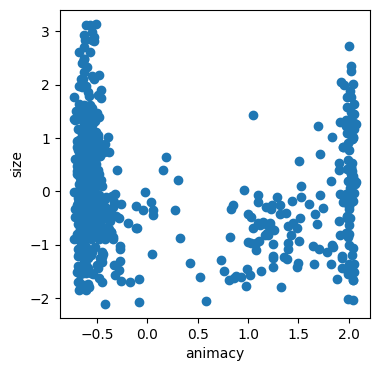

In [16]:
# inspect range/distribution of normalized regressors
fig = plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('animacy');plt.ylabel('size')
plt.show()

# Model fitting 🔁

Great! Now that we've assembled and preprocessed our data, we can run a model. For this demo, we'll use a simple linear regression pre-implemented in scikit-learn.

In [17]:
# fit a simple linear regression
n_jobs = 10
lr = LinearRegression(
    n_jobs=n_jobs, normalize=False, fit_intercept=True, 
)
lr.fit(X, y)

/home/ocontier/.conda/envs/thingsdata/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression(n_jobs=10, normalize=False)

# Visualizing and saving the results 💾

So far, we've used table data that doesn't contain information about where each voxel lies in space. However, we can easily transfer this data back into a volumetric space with the [brain masks, which you can also download from figshare](https://doi.org/10.25452/figshare.plus.20492757.v1).

In [18]:
# this is the brain mask file you should have downloaded
brainmask = pjoin(datadir, 'brainmasks', f'sub-01_space-T1w_brainmask.nii.gz')

In [19]:
# we can get the voxel-wise regression weights for both regressors from the linear regression object
weights = lr.coef_  # array of shape (nvoxel, nregressors)    

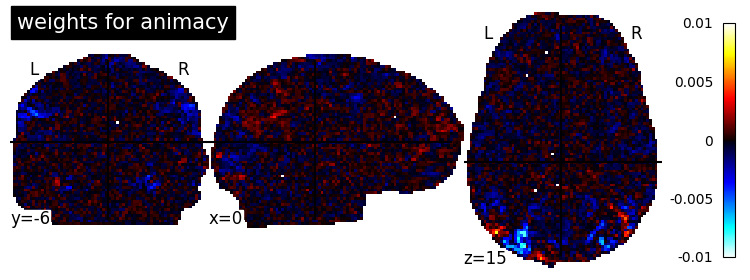

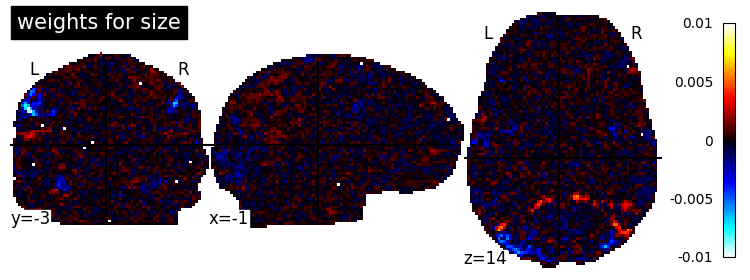

In [20]:
for w, regname in zip(weights.T, ['animacy', 'size']):
    # we'll unmask the weights to get a nibabel 3D volume object
    w_img = unmask(w, brainmask)
    # we can also take a look at the volume, e.g. with one of nilearn's plotting function
    fig = plot_stat_map(
        w_img, bg_img=None, colorbar=True, vmax=0.01,
        title=f'weights for {regname}',
        )
    # and save the volume to a nifti file
    w_img.to_filename(f'demo_weights_{regname}.nii.gz')